In [276]:
import numpy as np
import pandas as pd
import torch
torch.manual_seed(420)

In [277]:
df = pd.read_csv("/content/20231006144842322764.csv")
df.head()

,Unnamed: 0,time,qpos,qvel,qacc,ctrl
0,0,0.002,[ 1.79403415e-05 -9.44556617e-06],[ 0.00897017 -0.00472278],[ 4.49508657 -2.37690447],[0. 0.]
1,1,0.004,[ 5.37507060e-05 -2.82028654e-05],[ 0.01790518 -0.00937865],[ 4.47743035 -2.34329742],[9.99983333e-05 9.99950000e-03]
2,2,0.006,[ 1.07361654e-04 -5.61392935e-05],[ 0.02680547 -0.01396821],[ 4.45999466 -2.30999908],[0.00039997 0.019996 ]
3,3,0.008,[ 1.78704631e-04 -9.31234912e-05],[ 0.03567149 -0.0184921 ],[ 4.44278097 -2.2770134 ],[0.00089987 0.0299865 ]
4,4,0.010,[ 0.00026771 -0.00013903],[ 0.04450367 -0.02295093],[ 4.42579072 -2.24434425],[0.00159957 0.039968 ]


In [278]:
import torch
torch.manual_seed(420)


class PhysicsStatesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe
        self._preprocess()

    def read_transform(self, entity: str) -> list:
        entity = entity[1:-1]
        entities = entity.split(" ")
        numbers = []
        for number in entities:
          if number != '':
            numbers.append(float(number))
        return numbers

    def listify_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        new_df = df.copy()
        columns = ['qpos', 'qvel', 'qacc', 'ctrl']
        for column in columns:
            new_df[column] = new_df[column].apply(self.read_transform)
        return new_df

    def flatten_row(self, df_row)  -> list:
        states = np.array(df_row.values.flatten().tolist()).flatten()
        return states

    def _preprocess(self):
        self.dataframe = self.listify_dataframe(self.dataframe)
        self.dataframe = self.dataframe.drop(['Unnamed: 0', 'time'], axis=1)
        self.states = np.array([self.flatten_row(self.dataframe.iloc[i, :]) for i in range(len(self.dataframe))]).astype(np.float32)

    def _get_state(self, index: int) -> list:
        # retrieves a state from dataset by index
        return self.states[index]

    def _get_next_state(self, index: int) -> list:
        # retrieves next state withou control from dataset by index
        return self.states[index+1][:6]

    def __getitem__(self, index) -> tuple[list, list]:
        return self._get_state(index), self._get_next_state(index)

    def __len__(self) -> int:
        return len(self.states)-1

In [279]:
train_df = pd.read_csv("/content/20231006145359627330.csv")
train_dataset = PhysicsStatesDataset(train_df)


In [280]:
val_df = pd.read_csv("/content/20231006145432781317.csv")
val_dataset = PhysicsStatesDataset(val_df)

In [281]:
batch_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [282]:
for batch in train_dataloader:
    inp, out = batch
    print(inp.shape)
    print(out.shape)
    break

torch.Size([128, 8])
torch.Size([128, 6])


In [283]:
import torch.nn as nn

class LSTM_Physic(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):

        super().__init__()

        self.lstm = nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            batch_first = True,
                            dropout = dropout if n_layers > 1 else 0)


        self.seq = nn.Sequential(nn.Linear(input_dim, 256),
                                 nn.Sigmoid(),
                                 nn.Linear(256, 200),
                                 nn.Sigmoid(),
                                 nn.Linear(200, 128),
                                 nn.Sigmoid(),
                                 nn.Linear(128, 64),
                                 nn.Sigmoid(),
                                 nn.Linear(64, output_dim))

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, state):
        #state = [batch size, state dim]

        #pass state into LSTM
        outputs, (hidden, cell) = self.lstm(state)

        predictions = self.fc(self.dropout(outputs))

        #predictions = [sent len, batch size, output dim]
        return self.seq(state)

In [284]:
from tqdm.autonotebook import tqdm

def train_one_epoch(
    model,
    loader,
    optimizer,
    loss_fn,
    epoch_num=-1
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    model.train()
    train_loss = 0.0
    total = 0
    for i, batch in loop:
        states, next_states = batch
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass and loss calculation
        outputs = model(states)
        outputs = outputs.view(-1, outputs.shape[-1])

        loss = loss_fn(outputs,next_states)

        # backward pass
        loss.backward()
        total += next_states.size(0)

        # optimizer run
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix({"loss": train_loss/total})

def val_one_epoch(
    model,
    loader,
    loss_fn,
    epoch_num=-1,
    best_so_far=0.0,
    ckpt_path='best.pt'
):

    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for i, batch in loop:
            states, next_states = batch

            # forward pass and loss calculation
            outputs = model(states)
            outputs = outputs.view(-1, outputs.shape[-1])

            loss = loss_fn(outputs, next_states)

            total += next_states.size(0)

            val_loss += loss.item()
            loop.set_postfix({"loss": val_loss/total})

        if val_loss / total < best:
            torch.save(model.state_dict(), ckpt_path)
            return val_loss / total

    return best_so_far

In [285]:
INPUT_DIM = 8
HIDDEN_DIM = 10
OUTPUT_DIM = 6
N_LAYERS = 3
BIDIRECTIONAL = False
DROPOUT = 0.5

num_epochs = 20

model = LSTM_Physic(INPUT_DIM,
                    HIDDEN_DIM,
                    OUTPUT_DIM,
                    N_LAYERS,
                    BIDIRECTIONAL,
                    DROPOUT).to(device)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [286]:
best = float('inf')
for epoch in range(num_epochs):
    train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch)
    best_so_far = val_one_epoch(model, val_dataloader, loss_fn, epoch, best_so_far=best)

Epoch 0: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: val:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: val:   0%|          | 0/40 [00:00<?, ?it/s]

In [293]:
import matplotlib.pyplot as plt
def plot_results(dataset):
    plot_dataset = dataset
    plot_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    pos = [plot_dataset[i][0][:2] for i in range(len(plot_dataset))]
    plt.plot(pos)
    plt.title("True positions")
    plt.show()
    model.eval()
    outputs = []
    for batch in plot_dataloader:
        hui, pizda = batch
        if len(hui) < 128:
          break
        outputs.append(model(hui))

    outputs = torch.stack(outputs).flatten(0, 1)
    states = outputs.detach().numpy()
    pos = np.array([state[:2] for state in states])
    plt.title("Predicted by model positions")
    plt.plot(pos)
    plt.show()



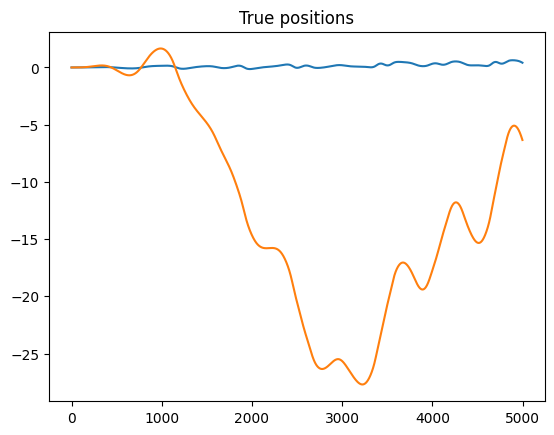

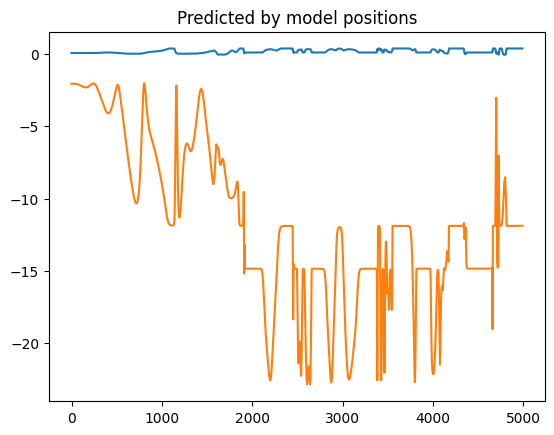

In [294]:
plot_results(train_dataset)

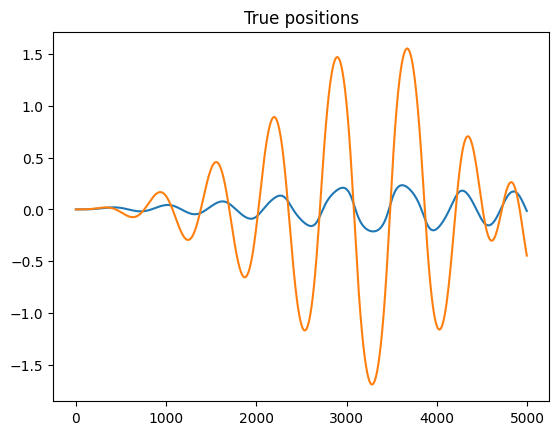

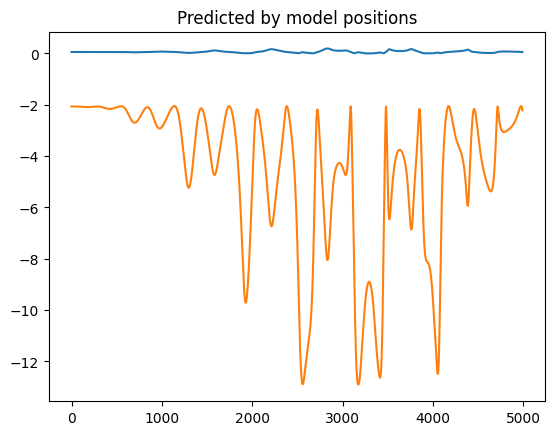

In [296]:
plot_results(val_dataset)